# Practical 3

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt  # needed later on

# Task 0: Preliminaries

This time we will work with a synthetic 2d dataset to facilitate visualization and be able to focus on the algorithms rather than spending energy to understand the dataset. The dataset consists of two classes and two predictors. Below we load the dataset and plot it.

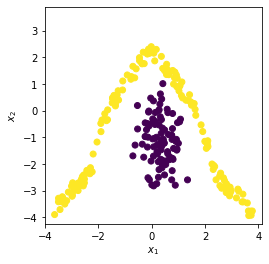

In [2]:
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:, :2], np.load('nonlin_2d_data.npy')[:, 2]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')

### Task 0.1

Apply logistic regression and LDA to the provided data, compute classification accuracy and plot the predictions. How do they perform? You're welcome to use sklearn for this task.

In [3]:
# Split data in training and test set
def split_data(y, X, split, seed=42):

    len_X = len(X)
    indices = np.random.permutation(len_X)
    indices_test, indices_train = indices[:int(len(indices)*split)], indices[int(len(indices)*split):]
    y_train, y_test = y[indices_train], y[indices_test]
    X_train, X_test = X[indices_train], X[indices_test]

    return y_train, y_test, X_train, X_test

In [4]:
y_train, y_test, X_train, X_test = split_data(y = t_2d, X = X_2d, split = (1/4))

In [5]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
# Nor Penalty
log_reg = LogisticRegression(random_state=2, penalty = "none").fit(y = y_train, X = X_train)
log_reg_score = log_reg.score(X_test, y_test)
log_reg_pred = log_reg.predict(X_test)
# L1 Norm needs different solver.
log_reg_l1 = LogisticRegression(random_state=2, penalty = "l1", solver = "liblinear").fit(y = y_train, X = X_train)
log_reg_l1_score = log_reg_l1.score(X_test, y_test)
log_reg_l1_pred = log_reg_l1.predict(X_test)
# L2 Norm.
log_reg_l2 = LogisticRegression(random_state=2, penalty = "l2").fit(y = y_train, X = X_train)
log_reg_l2_score = log_reg_l2.score(X_test, y_test)
log_reg_l2_pred = log_reg_l2.predict(X_test)

In [6]:
# Compare the accuracies/scores
## Coefficients
print('Coefficients:', '\n', 'Without', log_reg.coef_[0], '\n', 'L1-penalization', log_reg_l1.coef_[0], '\n', 'L2-penalization', log_reg_l2.coef_[0], '\n',) 
## Scores:
print('Scores:', '\n', 'Without', round(log_reg_score, 5), '\n', 'L1-penalization', round(log_reg_l1_score, 5), '\n', 'L2-penalization', round(log_reg_l2_score, 5))

Coefficients: 
 Without [-0.03058997  0.04555871] 
 L1-penalization [-0.02282556  0.02911151] 
 L2-penalization [-0.03040063  0.04520697] 

Scores: 
 Without 0.56452 
 L1-penalization 0.56452 
 L2-penalization 0.56452


In [7]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(y = y_train, X = X_train)
lda.score(X_test, y_test)
lda.coef_
print('Coefficients:', '\n', 'LDA', lda.coef_[0])

Coefficients: 
 LDA [-0.03068925  0.04513658]


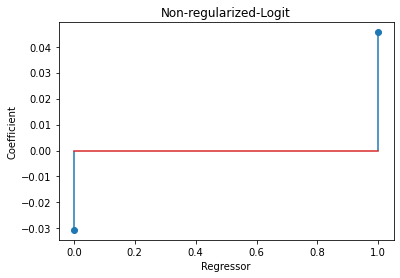

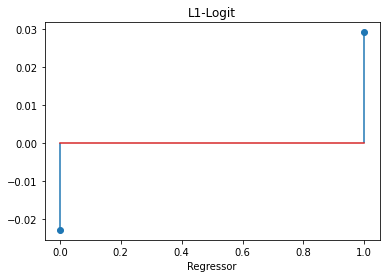

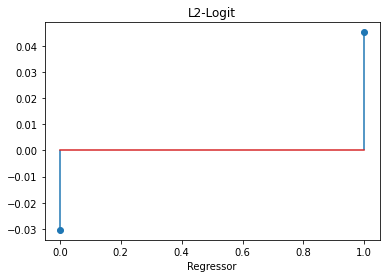

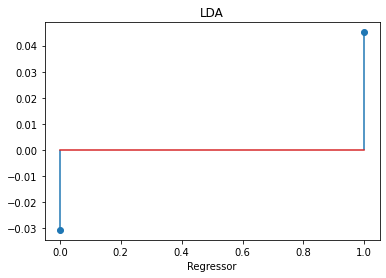

In [8]:
# Plots
## Plot for non-penalized regression
plt.stem(log_reg.coef_[0].flatten())
plt.title('Non-regularized-Logit')
plt.xlabel('Regressor')
plt.ylabel('Coefficient')
plt.show()
## Plot for L1-penalized regression
plt.stem(log_reg_l1.coef_[0].flatten())
plt.title('L1-Logit')
plt.xlabel('Regressor')
plt.show()
## Plot for L2-penalized regression
plt.stem(log_reg_l2.coef_[0].flatten())
plt.title('L2-Logit')
plt.xlabel('Regressor')
plt.show()
## Plot LDA
plt.stem(lda.coef_[0].flatten())
plt.title('LDA')
plt.xlabel('Regressor')
plt.show()

### Task 0.2

Implement the Gaussian RBF and visualize the pairwise similarities of `x`.

In [9]:
x = np.stack([np.sin(np.linspace(0, 8, 15)), np.cos(np.linspace(0, 7, 15))]).T

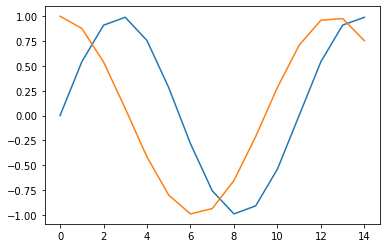

In [10]:
plt.plot(x)
plt.show()

In [11]:
# RBF kernel


In [12]:
# Visualize pairwise similarities


# Task 1: Kernel Discriminant Analysis

We will be implementing Kernel Discriminant Analysis, a nonlinear extension to LDA based on the kernel trick, following the original paper by Mika, Rätsch, Weston, Schölkopf and Müller (PDF on StudIP). Note, this is the original notation from the paper, mind the difference betweeen the matrix $M$ and the vectors $M_1, M_2$.

The goal of Kernel Discriminant Analysis is find a vector of $\alpha$'s that maximizes
$$ J(\alpha) = \frac{\alpha^T M \alpha}{\alpha^T N \alpha} $$
where
$$M := (M_1 - M_2)(M_1 - M_2)^T \text{ with } (M_i)_j = \frac{1}{l_i} \sum_{k=1}^{l_i} k(x_j, x_k^i)$$ and
$$N= \sum_{j=1,2} K_j (I - 1_{l_j}) K_j^T$$
Here, the number of samples for class $j$ is denoted by $l_j$. In the definition of $N$, $(K_{j})_{n,m} = k(x_n, x_m^j)$, $I$ is the identity matrix and $1_{l_j}$ is a matrix with each entry equal to $1/l_j$. $M_1, M_2$ have shape $(l_0 + l_1)$ each, $N$ and $M$ have shape $(l_0 + l_1) \times (l_0 + l_1)$.

We obtain the optimal solution by $\alpha = N^{-1}(M_1 - M_0)$. Note that you may have to regularize $N^{-1}$ for numerical stability (see paper or Wikipedia).

Prediction for an arbitrary sample $x$ is then carried out by building a weighted sum over it's kernel with the samples from the training set.

1. Implement a function `kda(X, t, kernel)` that carries out Kernel Discriminant Analysis on the data $X,t$ and returns a vector `alpha`.
2. Implement a function `def predict(x, X, alpha, kernel)`.
3. Visualize results given a linear kernel and a Gaussian Radial Basis Function kernel.

Use the following snippet as a starting point.

In [13]:
import seaborn as sns

In [14]:
def kda(X, t, kernel):
    l = [(t==0).sum(), (t==1).sum()]
    X_split = X[(t==0)], X[(t==1)]
    M = np.ones((2, len(X)))
    # N = np.ones((len(X), len(X)))
    K = np.ones((len(X), l[0])), np.ones((len(X), l[1]))

    # print(X_split[0].shape)
    # print(X_split[0][5,:])
    # print(kernel(X, X_split[0][5,:].T))
    for i in range(l[0]):
      M[0,:] += kernel(X, X_split[0][i,:].T)
    for i in range(l[1]):  
      M[1,:] += kernel(X, X_split[1][i,:].T)
    M[0,:] *= (1/l[0])
    M[1,:] *= (1/l[1])

    for i in range(2):
      for k in range(len(X)):
        for j in range(l[i]):
          K[i][k,j] = kernel(X[k,:], X_split[i][j,:].T)
          # K[i][k,j] = kernel(X_split[i][k],X_split[i][j].T)
    # print(K)
    # print(K[0].shape, K[1].shape)
    N = (K[0]@(np.eye(l[0])-(1/l[0]))@K[0].T) + (K[1]@(np.eye(l[1])-(1/l[1]))@K[1].T)
    # print(N)
    # print(N.shape)
    alpha = np.linalg.inv(N) @ (M[1,:] - M[0, :])
    thresh = alpha@ (0.5*(M[1,:]+M[0,:]))
    return alpha, thresh


def predict(alpha, x, kernel):
  y = 0
  for i in range(alpha.shape[0]):
    y += alpha[i] * kernel(X_train[i,:], x.T)
  return y

def linear_kernel(x_n, x_m):
    return x_n.dot(x_m)

def rbf_kernel(x_n, x_m, gamma=5, **kwargs):
    return np.exp(-np.power(x_n - x_m, 2).sum()/gamma)

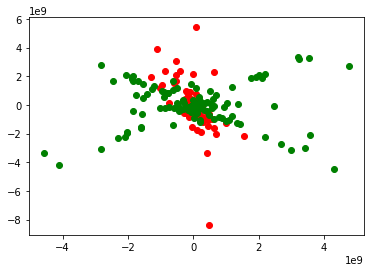

In [16]:
#kernel = linear_kernel
kernel = rbf_kernel
alpha, thresh = kda(X_train, y_train, kernel)
predictions = np.zeros((X_test.shape[0],1))
for i in range(X_test.shape[0]):
    predictions[i] = predict(alpha, X_test[i,:], kernel)

alpha = np.reshape(alpha, (188,1))

X_train_p = X_train * alpha
plt.scatter(X_train_p[y_train[:]==0,0], X_train_p[y_train[:]==0,1], c='red')
plt.scatter(X_train_p[y_train[:]==1,0], X_train_p[y_train[:]==1,1], c='green')
plt.show()

In [17]:
# Visualize results given a linear kernel and a Gaussian Radial Basis Function kernel.
split_data = X_train[(y_train == 0)], X_train[(y_train == 1)]

l_kernel_pred = []
g_kernel_pred = []

for sample in split_data[0]:
  l_kernel_pred.append(predict(alpha, sample, kernel = linear_kernel))

for sample in split_data[1]:
  g_kernel_pred.append(predict(alpha, sample, kernel= rbf_kernel))

c:\Git\ml-sose21\.mlvenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Git\ml-sose21\.mlvenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


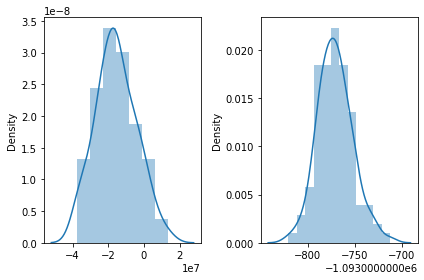

In [19]:
# _ = plt.hist(l_kernel_pred)
# _ = plt.hist(g_kernel_pred)
# plt.hist(l_kernel_pred, bins=10)
plt.subplot(1, 2, 1)
sns.distplot(l_kernel_pred)
plt.subplot(1, 2, 2)
sns.distplot(g_kernel_pred)
plt.tight_layout()
plt.show()

### Task 1.2

Which value would you use as a threshold to separate the classes? Use this threshold value to visualize the decision boundaries in a 2d grid (see example code below) and make predictions on the test set.

In [ ]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn([x, y]) for x, y, in zip(grid_x, grid_y)])
    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)


# The following example has the decision boundary at x[0] = 0.5
predict_fn = lambda x: x[0] > 0.5
plot_decision_boundary(predict_fn)

In [ ]:
# Visualize decision boundaries
???????? 